## Clamp_ vs. ReLU
This method compares using clamp_ in training vs. using a ReLU activation function to enforce non-negative estimates. Do the two approaches perform comparably?

In [27]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from functions import simulate_counts, plotsigs, cosine_perm

# Clamp_ model
Firstly we implement the NMFAE model, which is a one-hidden layer linear autoencoder. Here the non-negativity constraint is enforced by a clamp_ argument in the training method.

In [28]:
class NMFAE_clamp(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        # Building an linear encoder
        # 96 => dim1
        self.enc1 = torch.nn.Linear(96, dim1, bias = False)
          
        # Building an linear decoder 
        # dim1 ==> 96
        self.dec1 = torch.nn.Linear(dim1, 96, bias = False)
            

    def forward(self, x):
        x = self.enc1(x)
        x = self.dec1(x)
        return x
        
    # Model Initialization
                                
def train_NMFAE_clamp(epochs, model, x_train, loss_function, optimizer, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    for _ in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)


          optimizer.zero_grad() #clear old gradients
          loss.backward() #backpropagation
          optimizer.step() #update params
        #constrain the weights of the decoding layer to be non-negative  
        with torch.no_grad():
            for p in model.dec1.weight:
                p.clamp_(min = 0)
        
    return(model)

# ReLU model
Secondly we implement the same NMFAE model, but now the non-negativity constraint is enforced by introducing a ReLU activation function after encoding.

In [29]:
class NMFAE_relu(torch.nn.Module):
    def __init__(self, dim1):
    
        super().__init__()

        # Building an linear encoder
        # 96 => dim1
        self.enc1 = torch.nn.Linear(96, dim1, bias = False)
          
        # Building an linear decoder 
        # dim1 ==> 96
        self.dec1 = torch.nn.Linear(dim1, 96, bias = False)
            

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = self.dec1(x)
        return x
        
    # Model Initialization
                                
def train_NMFAE_relu(epochs, model, x_train, loss_function, optimizer, batch_size):
    
    #turn the training data into a tensor
    x_train_tensor = torch.tensor(x_train.values, 
                              dtype = torch.float32)
    
    #this is what loads makes the updates batch-wise insted of the full data matrix
    trainloader = torch.utils.data.DataLoader(x_train_tensor, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    
    for _ in range(epochs):
        model.train() #set model in traning mode (alternative model.eval())
        
        for data in trainloader:
          # Output of Autoencoder
          reconstructed = model(data)
            
          # Calculating the loss function
          loss = loss_function(reconstructed, data)


          optimizer.zero_grad() #clear old gradients
          loss.backward() #backpropagation
          optimizer.step() #update params
        
    return(model)

# Evaluate
Now we evaluate the results on simulated data.

In [30]:
V,S,E = simulate_counts(3, 2000)
m_clamp = NMFAE_clamp(3)
m_relu = NMFAE_relu(3)
trinucleotide = V.index
mutation = [t[2:5] for t in trinucleotide]


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(m_clamp.parameters(),
                            lr = 1e-3)
                            
train_NMFAE_clamp(epochs = 500, 
            model = m_clamp, 
            x_train = V.transpose(), 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size=6)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_clamp = m_clamp.dec1.weight.data    
sigs_clamp = pd.DataFrame(sigs_clamp.numpy()) 

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(m_relu.parameters(),
                            lr = 1e-3)
                            
train_NMFAE_relu(epochs = 500, 
            model = m_relu, 
            x_train = V.transpose(), 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size=6)


#the weights of the decoding layer (dec1) is where we find the signatures.
sigs_relu = F.relu(m_relu.dec1.weight.data)    
sigs_relu = pd.DataFrame(sigs_relu.numpy()) 


In [31]:
perm_clamp = cosine_perm(sigs_clamp.T, S.T)[1]
perm_relu = cosine_perm(sigs_relu.T, S.T)[1]

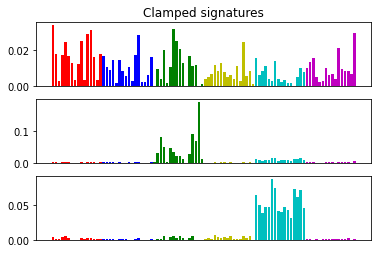

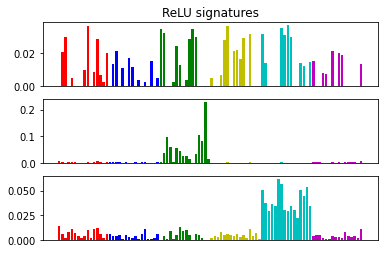

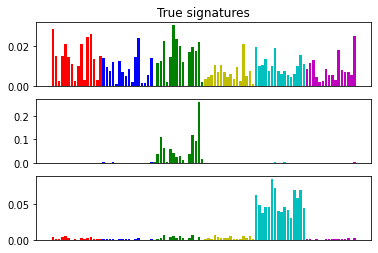

In [32]:
plotsigs(trinucleotide, mutation, sigs_clamp[perm_clamp].to_numpy(), 3, "Clamped signatures")  
plotsigs(trinucleotide, mutation, sigs_relu[perm_relu].to_numpy(), 3, "ReLU signatures")  
plotsigs(trinucleotide, mutation, S.to_numpy(), 3, "True signatures")  